In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library(vegan)
library(dplyr)
library(readr)
library(phyloseq)
library(ggplot2)
library(grid)

In [5]:
%%R
otu_tab = read_csv("data/EC_table.noMC.csv") %>% {
    rownames(.) = .$seq_id
    .
    } %>%
    select(-seq_id) %>%
    as.matrix %>%
    otu_table(taxa_are_rows = TRUE)

sample_tab = read_csv("data/sample_data.csv") %>% {
    rownames(.) = .$sample
    .
    } %>%
    select(-sample) %>%
    data.frame %>%
    sample_data


ps = phyloseq(otu_tab, sample_tab) %>%
    prune_samples((sampleSums(.) > 1000)&
                  (sample_data(.)$star %in% c("star", "W")), .)
  
ps   

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9467 taxa and 86 samples ]
sample_data() Sample Data:       [ 86 samples by 7 sample variables ]


In [6]:
%%R
sample_tab %>% add_rownames("Sample")

# A tibble: 184 × 8
     Sample Sample_number X96.Well.Plate.Location Sample.Amount
      <chr>         <int>                   <chr>         <chr>
1    CF1_CF             1                P1 - E12          1 mL
2    CF2_CF             2                P1 - F12          1 mL
3  X8106_PC             3                 P1 - A1      0.1145 g
4  X8532_CF             4                 P2 - A1          2 mL
5  X8533_TF             5                 P1 - B1       0.109 g
6   X8534_G             6                 P1 - C1      0.1306 g
7  X8535_PC             7                 P1 - D1      0.1013 g
8  X8507_CF             8                 P2 - B1          2 mL
9  X8508_TF             9                 P1 - E1      0.1078 g
10  X8509_G            10                 P1 - F1      0.1069 g
# ... with 174 more rows, and 4 more variables: Genus.Species <chr>,
#   Sample.Type <chr>, star <chr>, location <chr>


## Rarefaction Curve Calculations

In [16]:
%%R
rc = function(...){
    ff = "/dev/null" #tempfile()
    png(filename=ff)
    res = rarecurve(...)
    dev.off()
    unlink(ff)
    res
}

In [17]:
%%R
rare.max = sample_sums(ps) %>% max
rare.max

[1] 160056


In [18]:
%%R
otu_tab_raref = otu_table(ps) %>% as.matrix %>% t

In [19]:
%%R
rare.data = rc(otu_tab_raref, step = 100, sample = 50, label = FALSE)
names(rare.data) = rownames(otu_tab_raref)

In [21]:
%%R -h 500 -w 750
get_df = function(l) {
    data.frame(N = names(l), count = l) %>% 
        tbl_df %>%
        mutate(N = tidyr::extract_numeric(N))
}

rare_df = plyr::ldply(rare.data, get_df, .id = "Sample")
rare_df = rare_df %>%
    left_join(sample_tab %>% add_rownames("Sample"))

## Shannon Diversity Calculations

In [22]:
%%R
sha = estimate_richness(ps, split = TRUE, measures = "Shannon")
sha$Sample = rownames(sha)

dfsha = sha %>% left_join(sample_tab %>%  add_rownames("Sample"))

ordsha = dfsha %>% group_by(Sample.Type) %>%
    summarize(med.sha = median(Shannon)) %>%
    arrange(desc(med.sha)) %>%
    magrittr::extract2("Sample.Type")

dfsha$Sample.Type = factor(dfsha$Sample.Type, levels = ordsha)

In [59]:
%%R
stats = dfsha %>%
    group_by(Sample.Type) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) %>%
    arrange(desc(mean))
stats

# A tibble: 5 × 5
  Sample.Type   median     mean        sd        sem
       <fctr>    <dbl>    <dbl>     <dbl>      <dbl>
1          CF 4.029092 4.075887 0.4238032 0.09722712
2           W 4.229545 3.967992 0.5188716 0.15644567
3           G 2.961268 2.958140 0.7944776 0.20513324
4          TF 2.988083 2.635621 0.9984645 0.22906345
5          PC 2.960140 2.521083 1.2614206 0.26893577


## Chao1 Diversity Calculations

In [31]:
%%R

chao = estimate_richness(ps, split = TRUE, measures = "Chao1")
chao$Sample = rownames(chao)

dfchao = chao %>% left_join(sample_tab %>%  add_rownames("Sample"))

ordchao = dfchao %>% group_by(Sample.Type) %>%
    summarize(med.chao = median(Chao1)) %>%
    arrange(desc(med.chao)) %>%
    magrittr::extract2("Sample.Type")


dfchao$Sample.Type = factor(dfchao$Sample.Type, levels = ordchao)

In [32]:
%%R
dfchao %>%
    group_by(Sample.Type) %>%
    summarize(median(Chao1),mean(Chao1),max(Chao1))

# A tibble: 5 × 4
  Sample.Type `median(Chao1)` `mean(Chao1)` `max(Chao1)`
       <fctr>           <dbl>         <dbl>        <dbl>
1          CF             173      208.6316          595
2           W             168      173.3636          374
3          PC             107      105.5909          243
4          TF              99      123.8947          431
5           G              90      112.4667          417


## Simpson Diversity Calculations

In [50]:
%%R
simp = estimate_richness(ps, split = TRUE, measures = "Simpson")
simp$Sample = rownames(simp)

dfsimp = simp %>% left_join(sample_tab %>% add_rownames("Sample"))

ordsimp = dfsimp %>% group_by(Sample.Type) %>%
    summarize(med.simp = median(Simpson)) %>%
    arrange(desc(med.simp)) %>%
    magrittr::extract2("Sample.Type")

dfsimp$Sample.Type = factor(dfsimp$Sample.Type, levels = ordsimp)

## Making the Plots

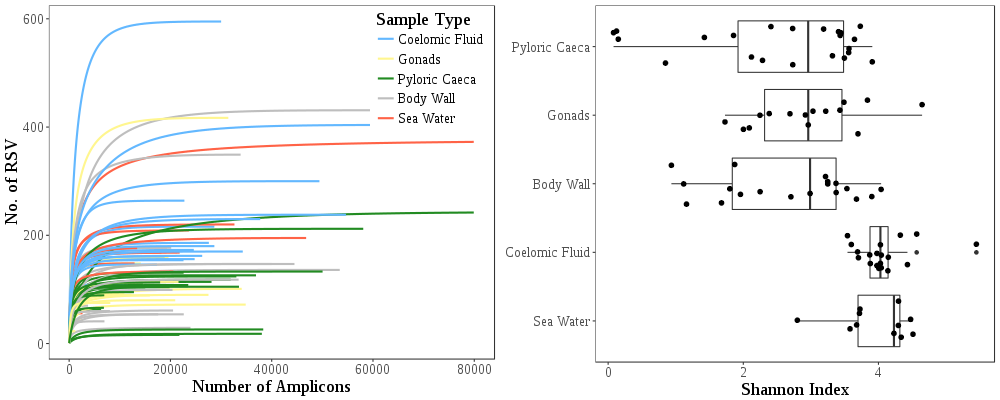

In [27]:
%%R -h 400 -w 1000

sampletype = c(
                    `PC` = "Pyloric Caeca",
                    `G` = "Gonads",
                    `CF` = "Coelomic Fluid",
                    `TF` = "Body Wall",
                    `W`  = "Sea Water"
                    )
## plot 1

p = ggplot(dfsha, aes(x = Sample.Type, y = Shannon))

p = p + geom_boxplot() + ylab("Shannon Index") + coord_flip()

p = p + geom_point(size = 2,# aes(color = Sample.Type),  
                   position = position_jitter(h = 0, w = 0.30))

p = p + theme_bw() + theme(text=element_text(size=18, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           legend.position = "none",
                           axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p = p + scale_x_discrete(breaks=c("PC", "G", "TF","CF","W"),
                      labels=c("Pyloric Caeca", "Gonads", "Body Wall","Coelomic Fluid","Sea Water"))

#p = p + scale_colour_manual(labels = sampletype,
#                              values = c("PC" = "forestgreen",
#                                       "G" = "khaki1",
#                                       "CF" = "steelblue1",
#                                       "TF" = "grey"))
p

## plot 2

#p2 = ggplot(dfsimp, aes(x = Sample.Type, y = Simpson))

#p2 = p2 + geom_boxplot() + ylab("Simpson Index") + coord_flip()

#p2 = p2 + geom_point(size = 1,# aes(color = "black"),  
#                   position = position_jitter(h = 0, w = 0.30))


#p2 = p2 + theme_bw() + theme(text=element_text(size=18, color="black",family="Times New Roman"),
#                           legend.key = element_blank(),
#                           axis.title.y=element_blank(),
#                           legend.position="none",
#                           panel.grid.major = element_blank(),
#                           panel.grid.minor = element_blank())

#p2 = p2 + scale_x_discrete(breaks=c("PC", "G", "TF","CF","W","S"),
 #                     labels=c("Pyloric Caeca", "Gonads", "Epidermis","Coelomic Fluid",
 #                              "Sea Water","Sediment"))

#p2

## plot 3

p3 = ggplot(rare_df, aes(x = N, y = count, group = Sample)) + labs(color = "Sample Type")

p3 = p3 + geom_line(size=1,aes(color = Sample.Type)) + ylab("No. of RSV") + xlab("Number of Amplicons") 

p3 = p3 + theme_bw() + theme(text=element_text(size=18, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           legend.key.size = unit(0.7, "cm"),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.justification=c(0.9,0.9), legend.position=c(0.96,0.96))

p3 = p3 + scale_y_continuous(breaks = seq(0,2000,200)) + xlim(0,80000)


p3 = p3 + scale_colour_manual(labels = sampletype,
                              values = c("PC" = "forestgreen",
                                       "G" = "khaki1",
                                       "CF" = "steelblue1",
                                       "TF" = "grey",
                                        "W" = "tomato1"))

p3

## plot 4


#p4 = ggplot(dfchao, aes(x = Sample.Type, y = Chao1))

#p4 = p4 + geom_boxplot() + ylab("Chao1 Index") + coord_flip()

#p4 = p4 + geom_point(size = 1, position = position_jitter(h = 0, w = 0.30))

#p4 = p4 + theme_bw() + theme(text=element_text(size=18, color="black",family="Times New Roman"),
 #                          legend.key = element_blank(),
 #                          axis.title.y=element_blank(),
 #                          legend.position="none",
 #                          panel.grid.major = element_blank(),
 #                          panel.grid.minor = element_blank())

#p4 = p4 + scale_x_discrete(breaks=c("PC", "G", "TF","CF","W","S"),
 #                     labels=c("Pyloric Caeca", "Gonads", "Epidermis","Coelomic Fluid",
 #                              "Sea Water","Sediment"))

#p4 = p4 + scale_y_continuous(breaks = seq(0,2000,200))

#p4

gridExtra::grid.arrange(p3,p, ncol=2, nrow = 1) 
             #layout_matrix = rbind(c(1,1), c(3,2)))

